### fitting JHK+Gaia, and parallax 

In [1]:
from jaxstar import mistfit
from jax import random
import arviz, corner
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline

In [3]:
mf = mistfit.MistFit()

In [4]:
# observed Kmag, Teff, Fe/H, parallax (mas)
jmag_obs, jmag_err, hmag_obs, hmag_err, kmag_obs, kmag_err, parallax_obs, parallax_err\
= [ 7.844, 0.021, 7.255, 0.020, 7.104, 0.017, 35.666, 0.014]

In [5]:
gmag_obs, bpmag_obs, rpmag_obs = [9.72, 10.4, 8.90]
gmag_err, bpmag_err, rpmag_err = np.ones(3)*0.05

In [6]:
# probably need to know Fe/H for accurete modeling
feh_est, feh_err = -0.58, 0.18

In [7]:
mf.set_data(['gmag', 'bpmag', 'rpmag']+['jmag', 'hmag', 'kmag', 'parallax', 'feh'],\
            [gmag_obs, bpmag_obs, rpmag_obs]+[jmag_obs, hmag_obs, kmag_obs, parallax_obs, feh_est],\
            [gmag_err, bpmag_err, rpmag_err]+[jmag_err, hmag_err, kmag_err, parallax_err, feh_err])

In [8]:
# setup HMC
ns = 5000
mf.setup_hmc(num_warmup=ns, num_samples=ns)

In [9]:
# run
rng_key = random.PRNGKey(0)
mf.run_hmc(rng_key, linear_age=True, flat_age_marginal=False, nodata=False)

sample: 100%|███████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 580.08it/s, 511 steps of size 3.53e-03. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       age      6.93      3.85      6.97      1.01     13.09   1015.42      1.00
  distance      0.03      0.00      0.03      0.03      0.03   3451.22      1.00
       eep    313.52     23.68    320.96    278.68    338.78    779.67      1.00
       feh     -0.24      0.06     -0.23     -0.33     -0.15   1433.49      1.00

Number of divergences: 0


In [10]:
mcmc = mf.mcmc
samples = mf.samples

In [15]:
for key in ['jmag', 'hmag', 'kmag', 'gmag', 'bpmag', 'rpmag']:
    print (key, "(obs-model)", np.mean(globals()[key+"_obs"]-samples[key]))

jmag (obs-model) -0.06564638763666153
hmag (obs-model) 0.0396963395178318
kmag (obs-model) -0.0006717234500683844
gmag (obs-model) 0.0426616370677948
bpmag (obs-model) 0.05662807449698448
rpmag (obs-model) -0.004125624895095825


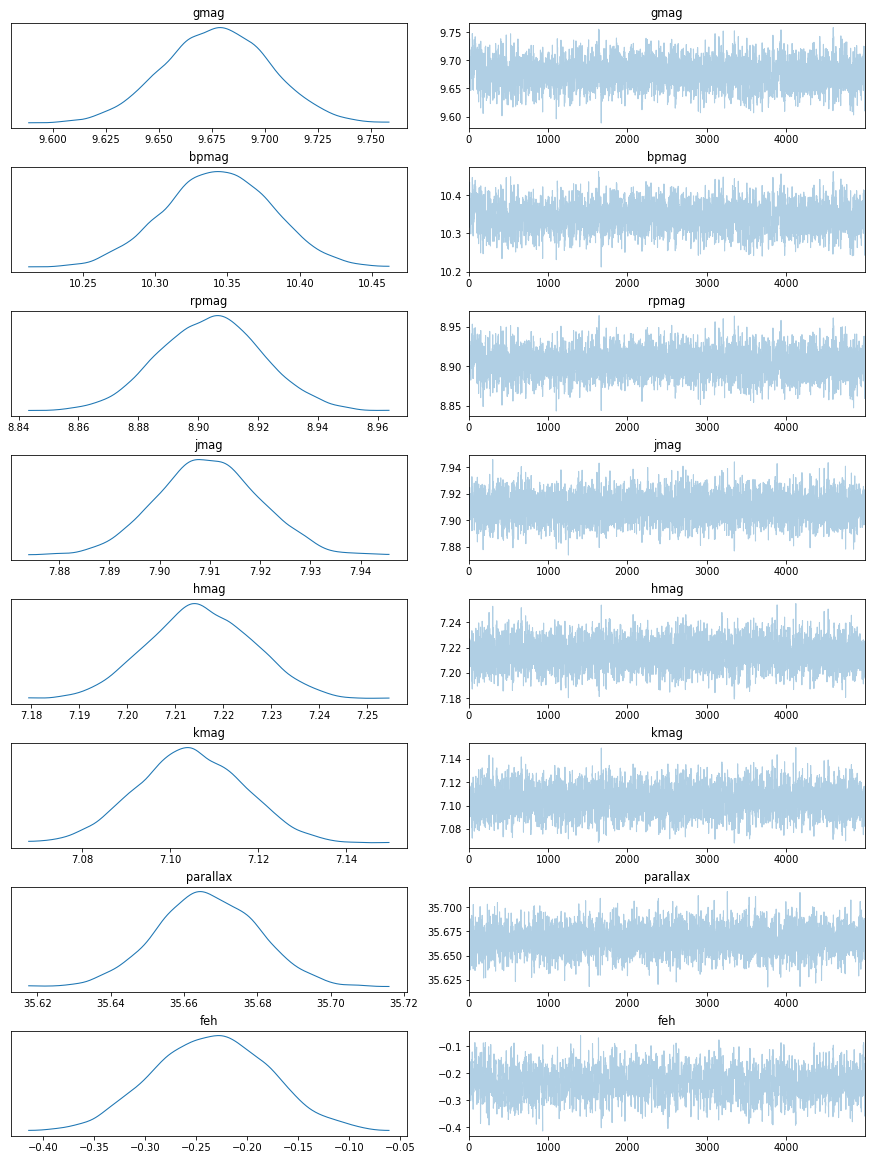

In [12]:
# trace plot
fig = arviz.plot_trace(mcmc, var_names=mf.obskeys)

In [13]:
# keys and observed values for corner plot
outkeys = mf.obskeys + ['mass', 'radius', 'age', 'teff', 'logg', 'eep']
obsvals = mf.obsvals + [None] * (len(outkeys) - len(mf.obskeys))

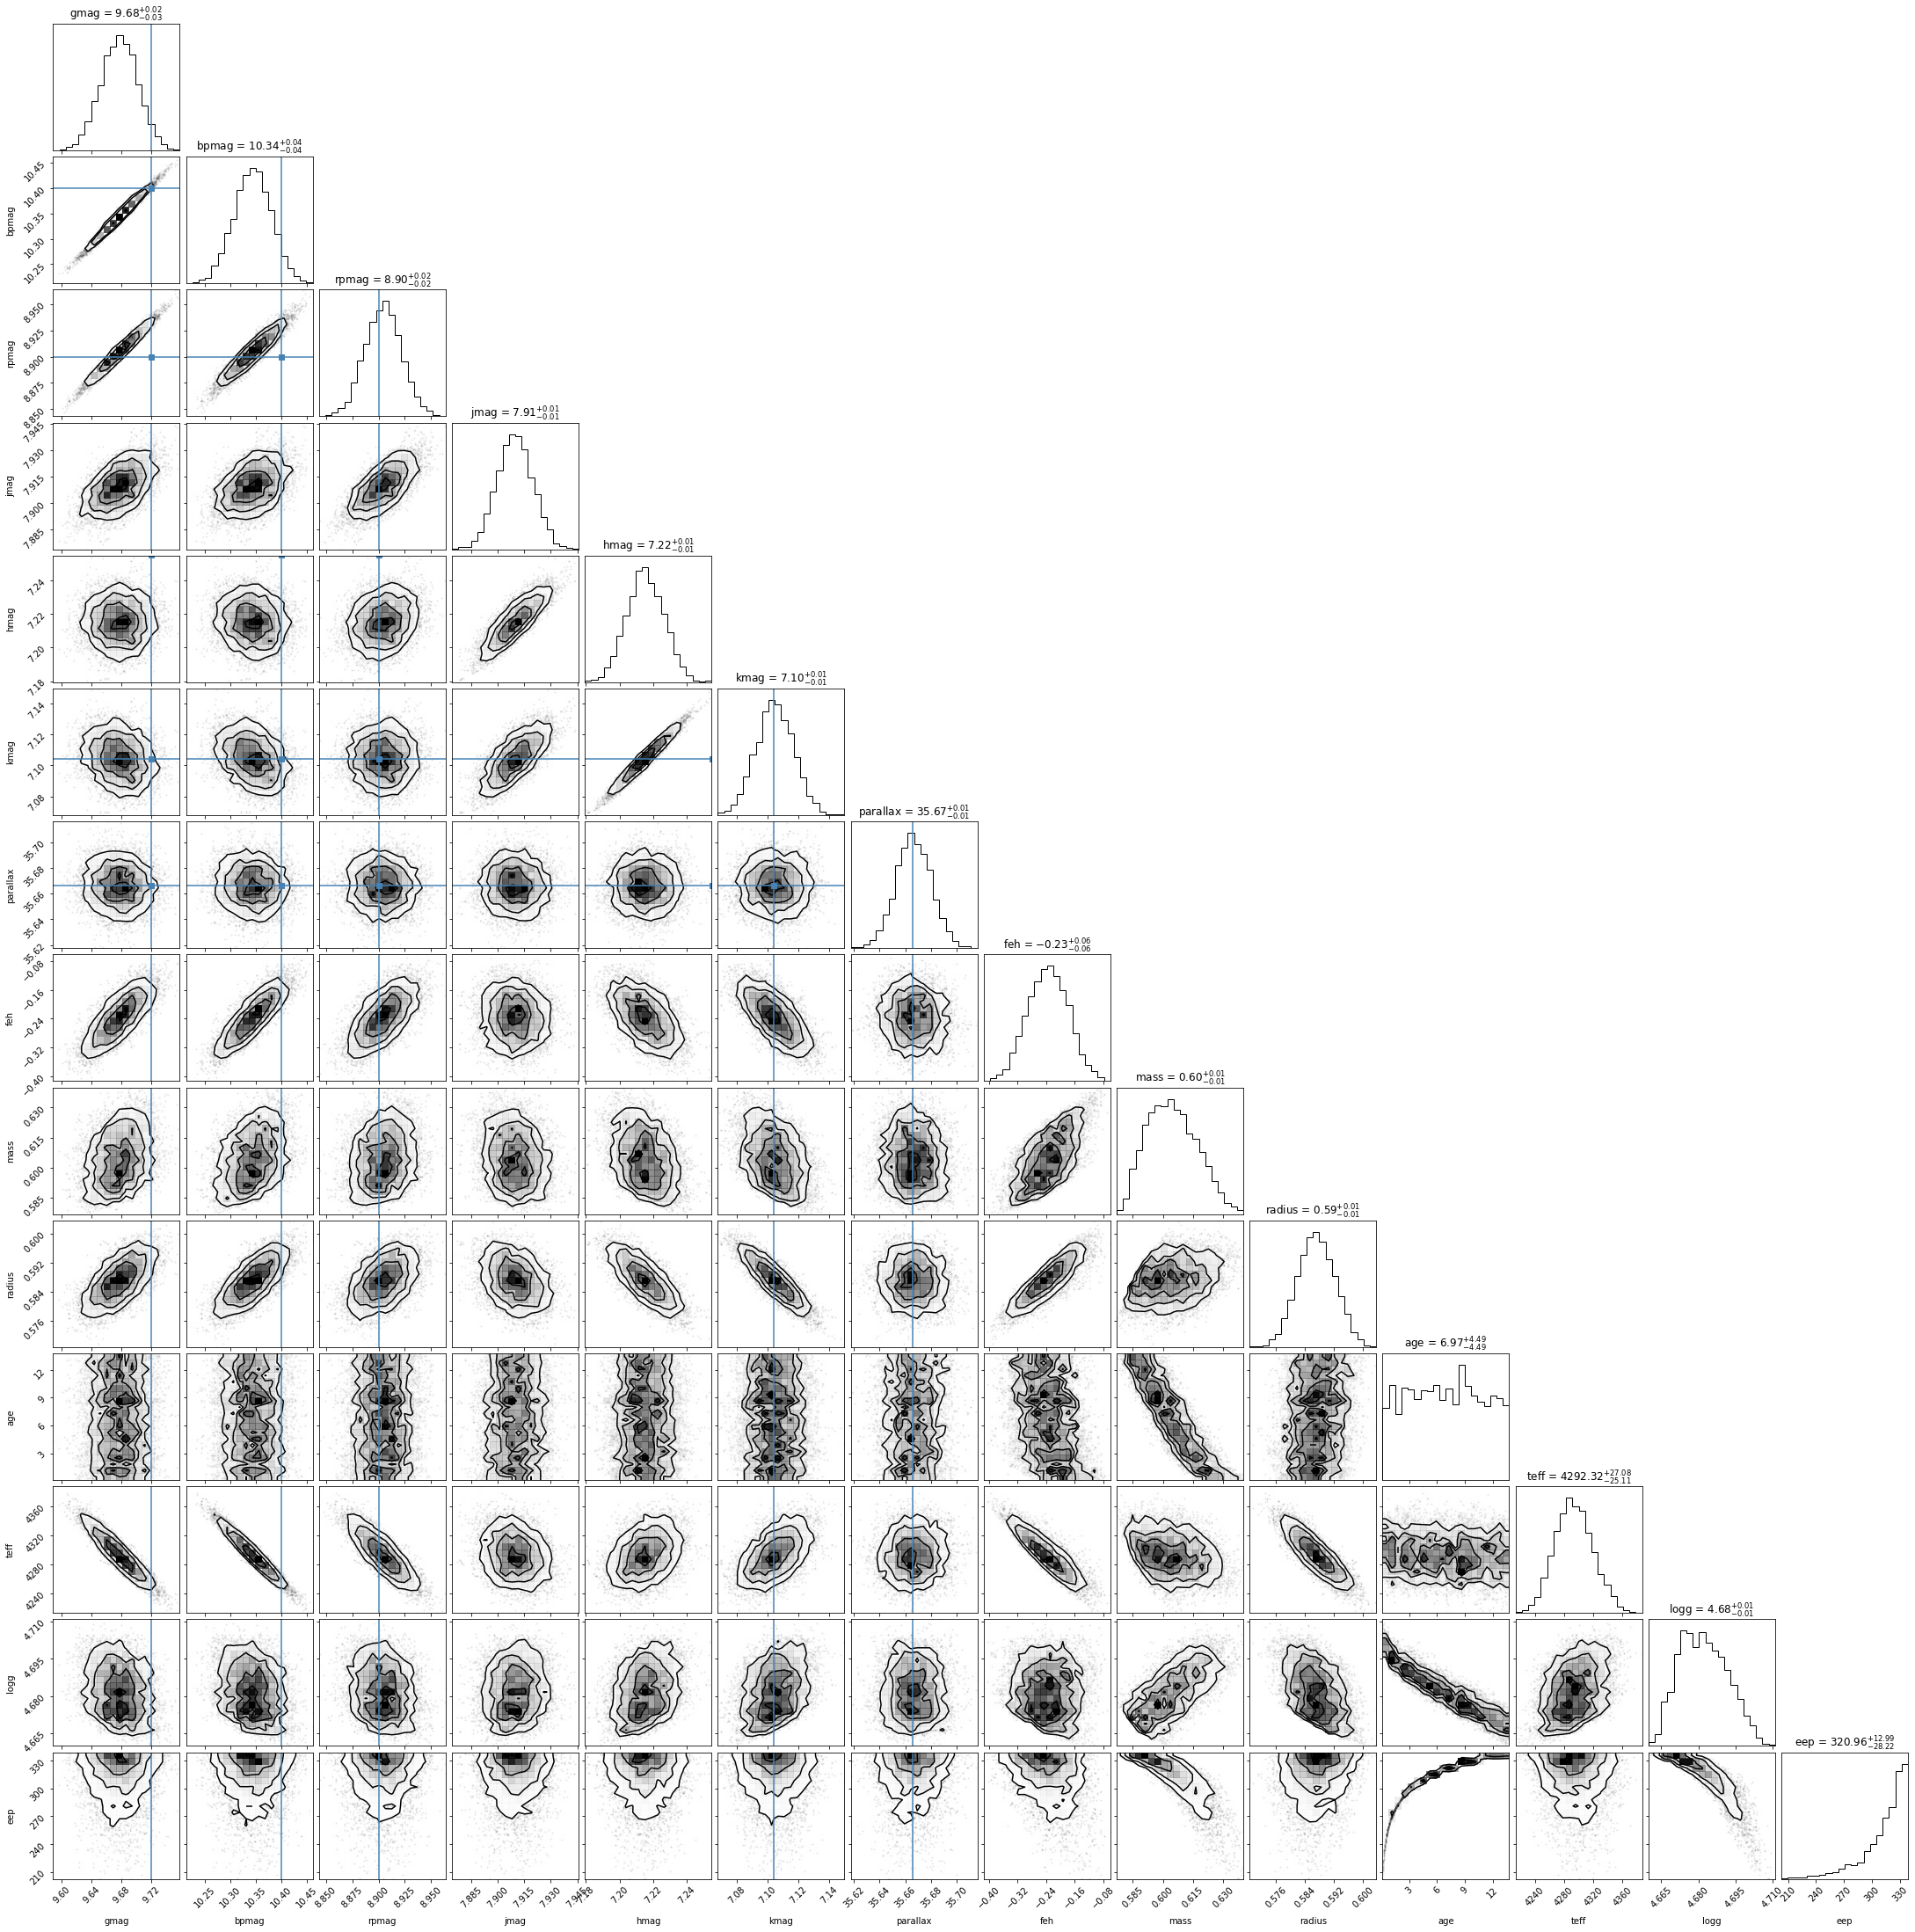

In [14]:
params = pd.DataFrame(data=dict(zip(outkeys, [samples[k] for k in outkeys])))
fig = corner.corner(params, show_titles="%.2f", truths=obsvals)